In [1]:
import scanpy as sc
import anndata as ad
from glob import glob

In [2]:
print(sc.__version__)

1.9.3+computecanada


Scanpy has weird default values that are often immediately changed by convention. The first is that scanpy by default will only show warning+error messages. We would like to change this as it also offers 'Hints' if you set verbosity to 3.

In [3]:
sc.settings.verbosity = 3

## Data Import

Here we are simply iterating through all of the '*/outs/filtered_feature_bc_matrix' directories and importing the single cell dataset into a scanpy object. 

1. I generate a list of directory paths to cellranger output directories
2. I generate a dictionary containing anndata objects with sample_name as  `keys`
3. I concatinate these anndata objects into a single dataset 
4. I ensure that all the obs and var are unique

In [4]:
import warnings
warnings.filterwarnings("ignore", message="Variable names are not unique.", category=UserWarning)

outpath = '/home/garvena/projects/def-dmberman/garvena/singlecellseq/Data/Scrublet/Lai'
dirpaths = glob('/home/garvena/projects/def-dmberman/garvena/singlecellseq/Data/Scrublet/Lai/*_scrub.h5')

adatas = {dirpath.split('/')[10].split('_')[0]: sc.read_h5ad(dirpath) for dirpath in dirpaths}
adata = ad.concat(adatas.values(), label='sample')

/home/garvena/projects/def-dmberman/garvena/singlecellseq/ENV/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


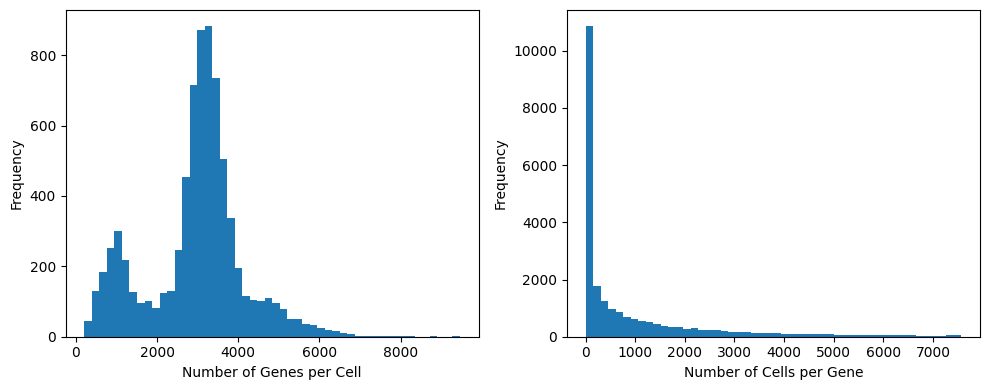

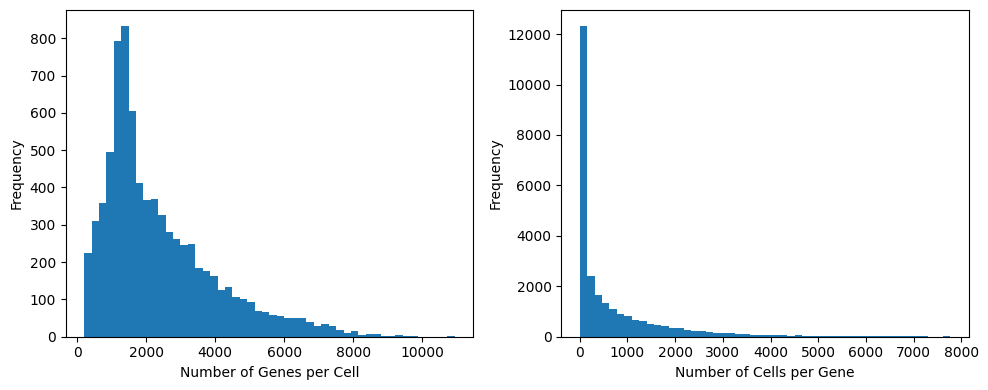

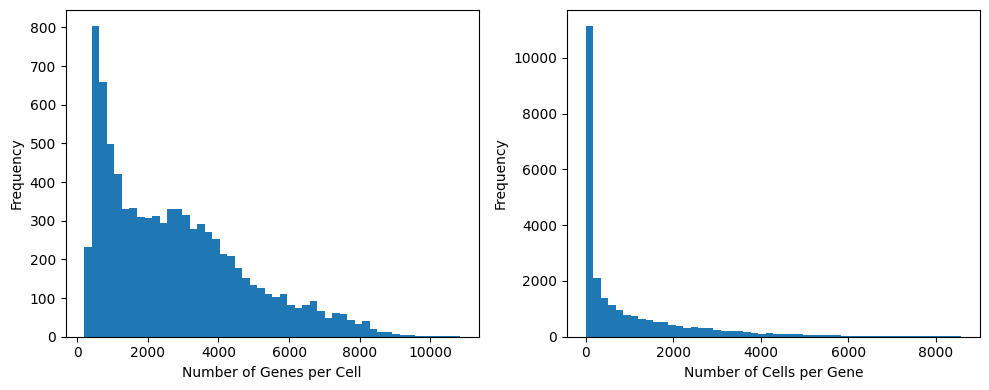

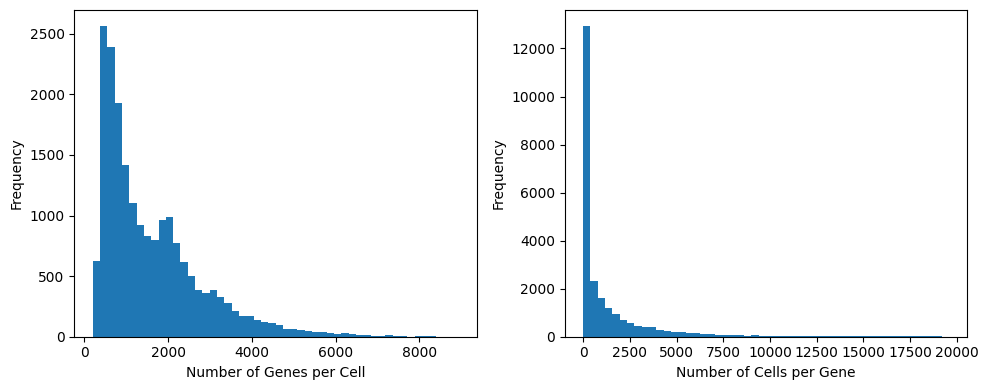

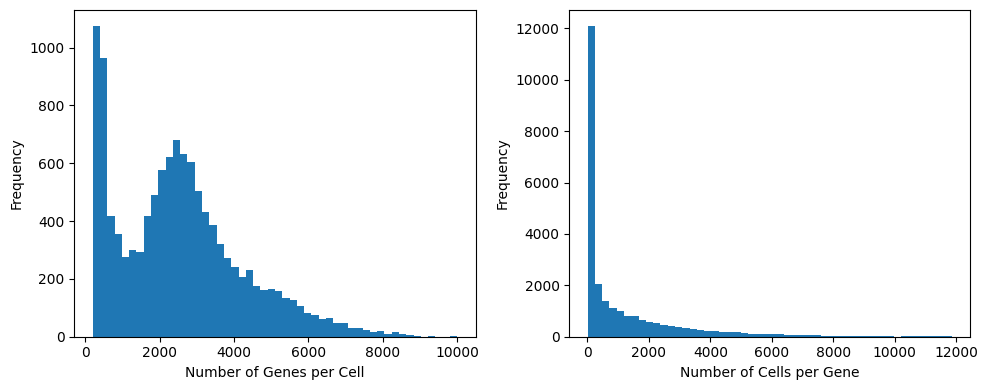

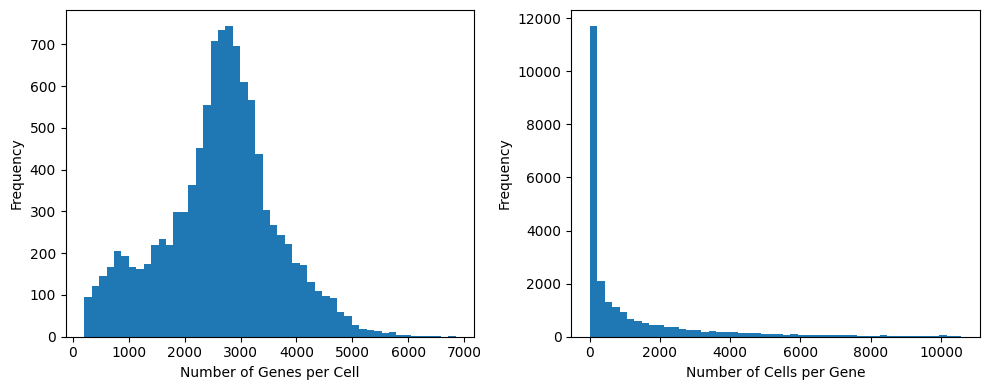

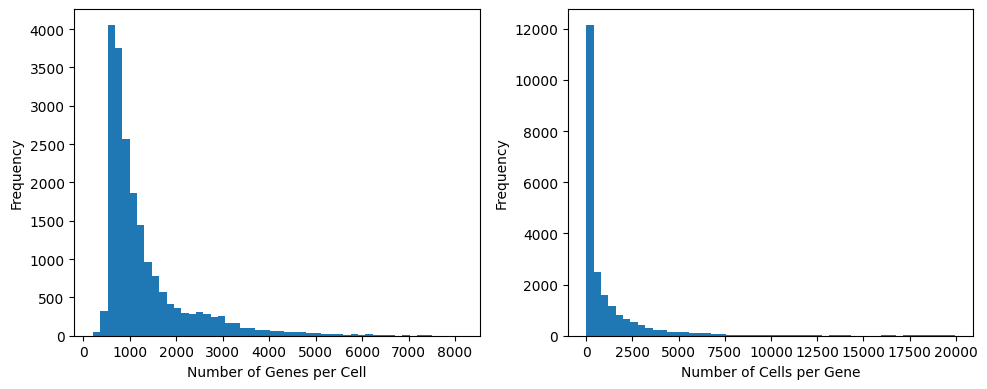

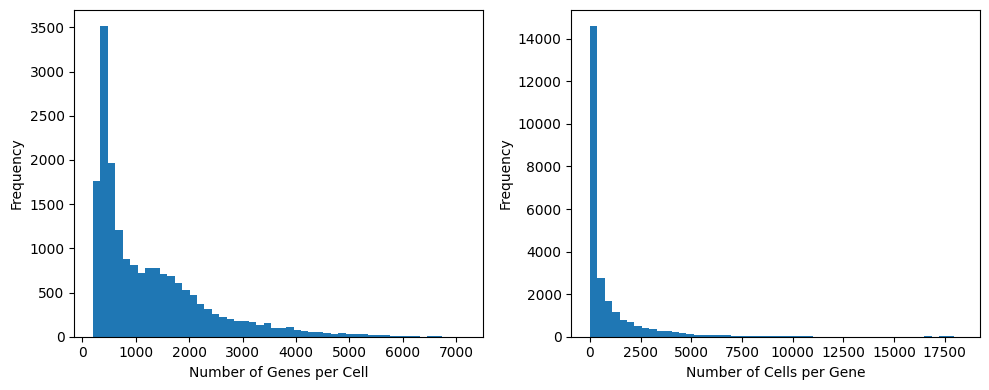

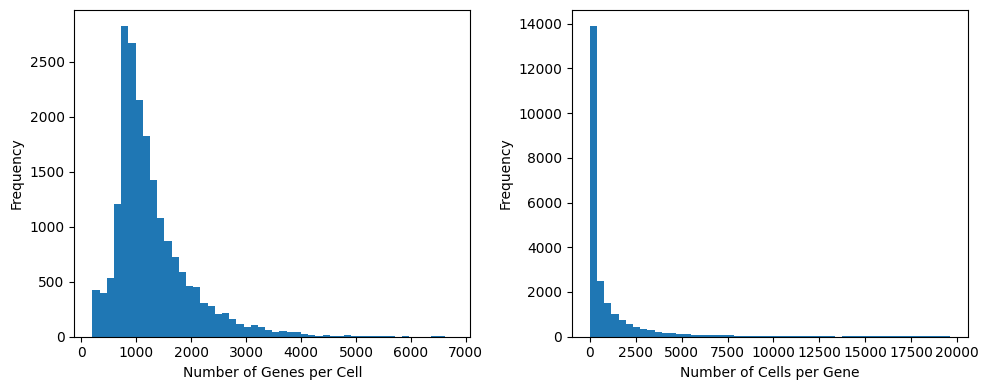

In [8]:
import matplotlib.pyplot as plt

for adata in adatas.values():
    sc.pp.filter_cells(adata, min_genes=0)
    gene_counts_per_cell = adata.obs['n_genes']
    sc.pp.filter_genes(adata, min_cells=0)
    cell_counts_per_gene = adata.var['n_cells']
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(gene_counts_per_cell, bins=50)
    plt.xlabel('Number of Genes per Cell')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(cell_counts_per_gene, bins=50)
    plt.xlabel('Number of Cells per Gene')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

## Quality Control

In [5]:
# mitochondrial genes, "MT-" for human
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

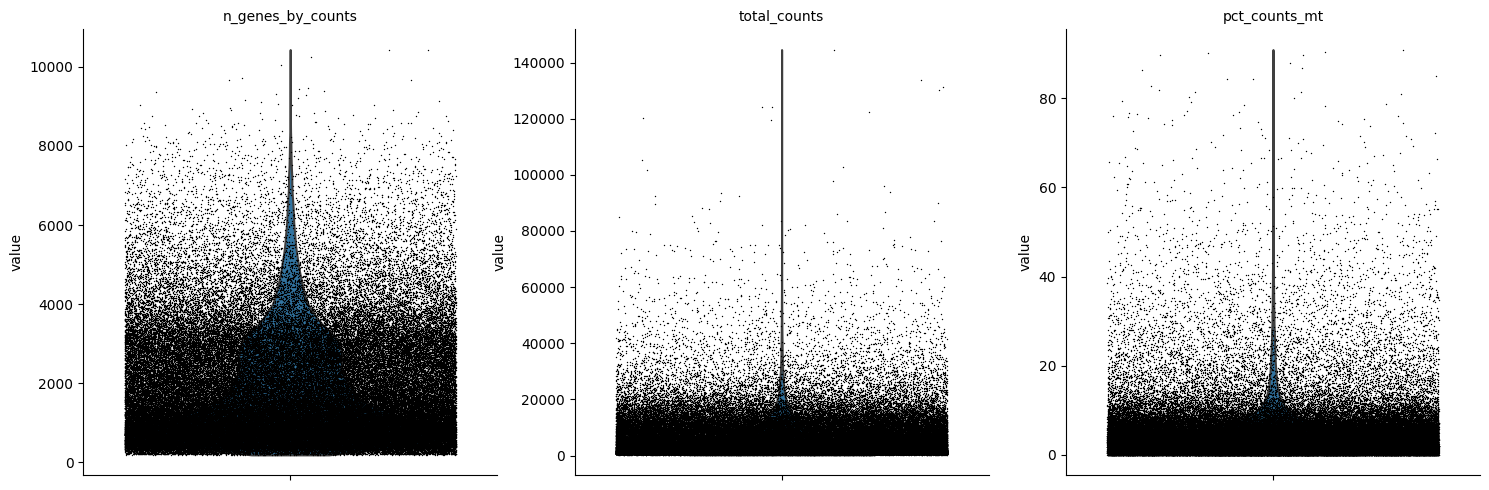

In [7]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

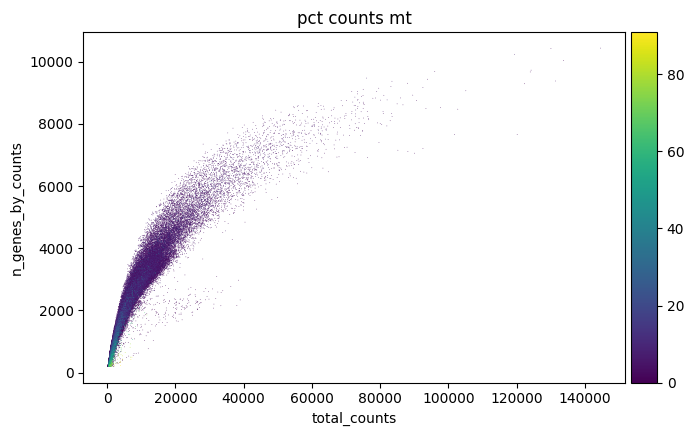

In [8]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [9]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:30)


## Feature Selection

In [10]:
sc.pp.highly_variable_genes(adata, batch_key="sample")

extracting highly variable genes
    finished (0:01:38)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


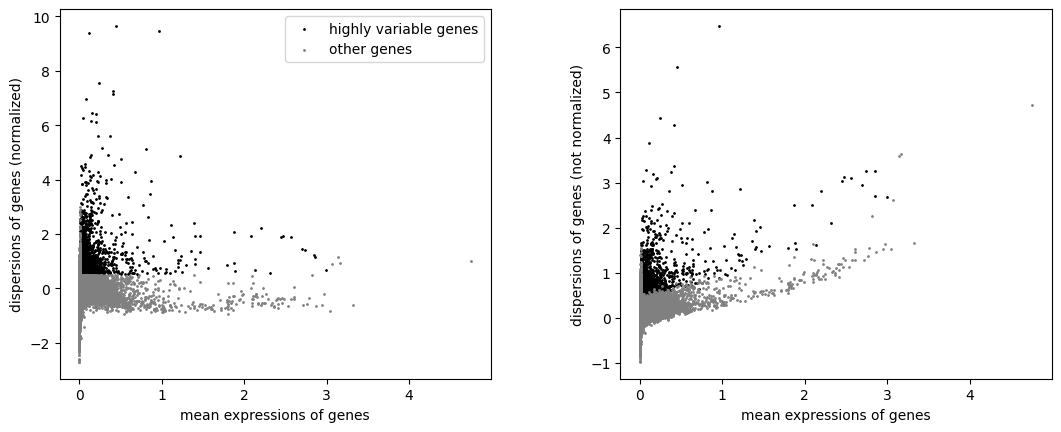

In [11]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction (PCA)

In [12]:
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:23)


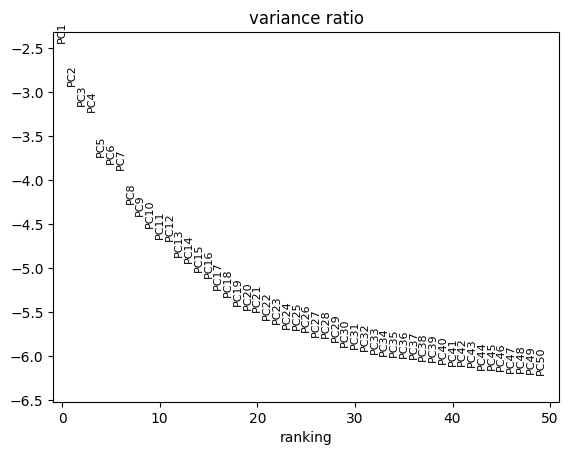

In [13]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

/home/garvena/projects/def-dmberman/garvena/singlecellseq/ENV/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/garvena/projects/def-dmberman/garvena/singlecellseq/ENV/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/garvena/projects/def-dmberman/garvena/singlecellseq/ENV/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/garvena/projects/def-dmberman/garvena/singlecellseq/ENV/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


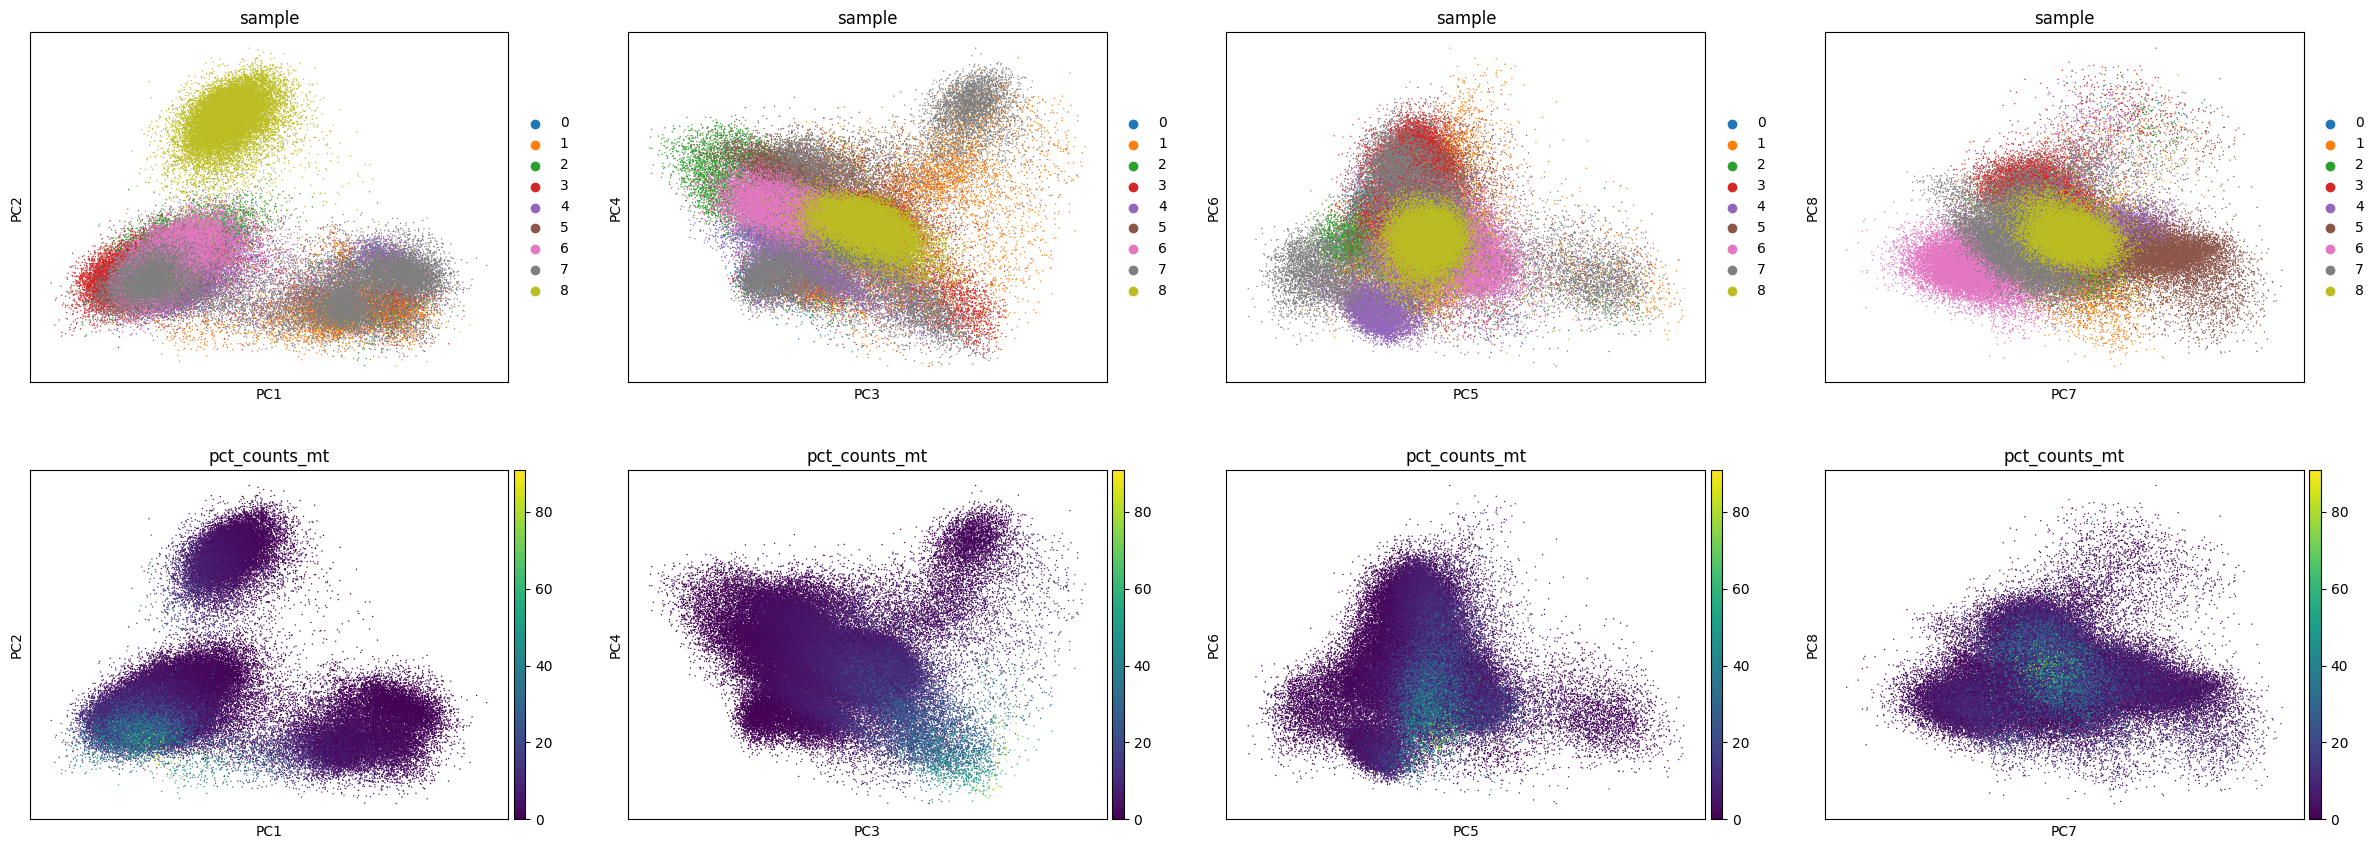

In [14]:
sc.pl.pca(
    adata,
    color=['sample', 'sample', 'sample', 'sample',
           'pct_counts_mt', 'pct_counts_mt', 'pct_counts_mt', 'pct_counts_mt'],
    dimensions=[(0, 1), (2, 3), (4, 5), (6, 7),
               (0, 1), (2, 3), (4, 5), (6, 7)],
    ncols=4,
    size=4,
)

In [15]:
sc.write('/home/garvena/projects/def-dmberman/garvena/singlecellseq/Data/Scanorama/Lai/Input/input_scanorama.h5ad', adata)

In [3]:
adata = sc.read_h5ad('/home/garvena/projects/def-dmberman/garvena/singlecellseq/Data/Scanorama/Lai/Input/input_scanorama.h5ad')

/home/garvena/projects/def-dmberman/garvena/singlecellseq/ENV/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Nearest Neighbour Graph Construction

In [16]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:23)


In [17]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:16)


/home/garvena/projects/def-dmberman/garvena/singlecellseq/ENV/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


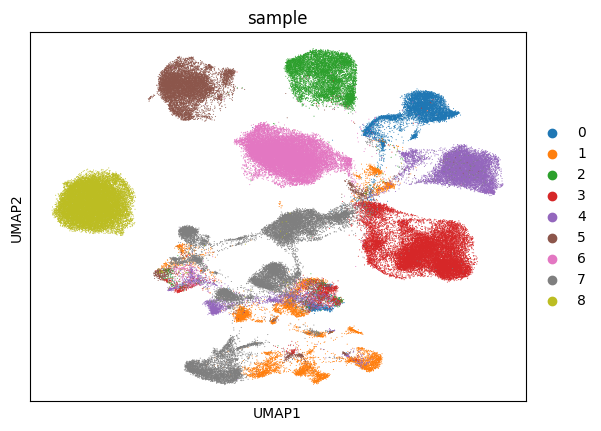

In [18]:
sc.pl.umap(
    adata,
    color="sample",
    size=2,
)

In [4]:
sc.external.pp.scanorama_integrate(adata,
                                   key="sample",
                                   verbose=1)

: 